In [3]:
import os
import sys 

# Modify the path 
sys.path.append("..")

import pandas as pd
import yellowbrick as yb
import matplotlib.pyplot as plt 

In [4]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import CVScores


room = pd.read_csv('data/occupancy/occupancy.csv')

features = ["temperature", "relative humidity", "light", "C02", "humidity"]

# Extract the numpy arrays from the data frame
X = room[features].values
y = room.occupancy.values

# Create a cross-validation strategy
cv = StratifiedKFold(12)

# Create the cv score visualizer
oz = CVScores(RidgeClassifier(), cv=cv)

oz.fit(X, y)
oz.poof()

In [5]:
# yellowbrick.model_selection.cross_validation
# Implements cross-validation score plotting for model selection.
#
# Author:   Prema Damodaran Roman
# Created:  Wed June 6 2018 13:32:00 -0500
# Author:   Rebecca Bilbro <bilbro@gmail.com>
# Updated:  Fri Aug 10 13:15:43 2018 -0500
#
# ID: cross_validation.py [7f47800] pdamo24@gmail.com $

"""
Implements cross-validation score plotting for model selection.
"""

##########################################################################
## Imports
##########################################################################

import numpy as np
import matplotlib.ticker as ticker

from yellowbrick.base import ModelVisualizer
from sklearn.model_selection import cross_val_score


##########################################################################
## CVScores Visualizer
##########################################################################

class CVScores(ModelVisualizer):
    """
    CVScores displays cross-validated scores as a bar chart, with the
    average of the scores plotted as a horizontal line.

    Parameters
    ----------

    model : a scikit-learn estimator
        An object that implements ``fit`` and ``predict``, can be a
        classifier, regressor, or clusterer so long as there is also a valid
        associated scoring metric.
        Note that the object is cloned for each validation.

    ax : matplotlib.Axes object, optional
        The axes object to plot the figure on.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 3-fold cross-validation,
        - integer, to specify the number of folds.
        - An object to be used as a cross-validation generator.
        - An iterable yielding train/test splits.

        See the scikit-learn `cross-validation guide <https://goo.gl/FS3VU6>`_
        for more information on the possible strategies that can be used here.

    scoring : string, callable or None, optional, default: None
        A string or scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

        See scikit-learn `cross-validation guide <https://goo.gl/FS3VU6>`_
        for more information on the possible metrics that can be used.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Examples
    --------

    >>> from sklearn import datasets, svm
    >>> iris = datasets.load_iris()
    >>> clf = svm.SVC(kernel='linear', C=1)
    >>> X = iris.data
    >>> y = iris.target
    >>> visualizer = CVScores(model=clf, cv=5, scoring='f1_macro')
    >>> visualizer.fit(X,y)
    >>> visualizer.poof()

    Notes
    -----

    This visualizer is a wrapper for
    `sklearn.model_selection.cross_val_score <https://goo.gl/4v7dfL>`_.

    Refer to the scikit-learn
    `cross-validation guide <https://goo.gl/FS3VU6>`_
    for more details.

    """

    def __init__(self, model, ax=None, cv=None, scoring=None, **kwargs):
        super(CVScores, self).__init__(model, ax=ax, **kwargs)

        self.cv = cv
        self.scoring = scoring

    def fit(self, X, y, **kwargs):
        """
        Fits the learning curve with the wrapped model to the specified data.
        Draws training and test score curves and saves the scores to the
        estimator.

        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : array-like, shape (n_samples) or (n_samples, n_features), optional
            Target relative to X for classification or regression;
            None for unsupervised learning.

        Returns
        -------
        self : instance

        """

        self.cv_scores_ = cross_val_score(
            self.estimator, X, y, cv=self.cv, scoring=self.scoring
        )
        self.cv_scores_mean_ = self.cv_scores_.mean()

        self.draw()
        return self

    def draw(self, **kwargs):
        """
        Creates the bar chart of the cross-validated scores generated from the
        fit method and places a dashed horizontal line that represents the
        average value of the scores.
        """

        color = kwargs.pop("color", "b")
        width = kwargs.pop("width", 0.3)
        linewidth = kwargs.pop("linewidth", 1)

        xvals = np.arange(1, len(self.cv_scores_) + 1, 1)
        self.ax.bar(xvals, self.cv_scores_, width=width)
        self.ax.axhline(
            self.cv_scores_mean_, color=color,
            label="Mean score = {:0.3f}".format(self.cv_scores_mean_),
            linestyle='--', linewidth=linewidth
        )

        return self.ax

    def finalize(self, **kwargs):
        """
        Add the title, legend, and other visual final touches to the plot.
        """

        # Set the title of the figure
        self.set_title('Cross Validation Scores for {}'.format(self.name))

        # Add the legend
        loc = kwargs.pop("loc", "best")
        edgecolor = kwargs.pop("edgecolor", "k")
        self.ax.legend(frameon=True, loc=loc, edgecolor=edgecolor)

        # set spacing between the x ticks
        self.ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

        # Set the axis labels
        self.ax.set_xlabel('Training Instances')
        self.ax.set_ylabel('Score')


##########################################################################
## Quick Method
##########################################################################

def cv_scores(model, X, y, ax=None, cv=None, scoring=None, **kwargs):
    """
    Displays cross validation scores as a bar chart and the
    average of the scores as a horizontal line

    This helper function is a quick wrapper to utilize the
    CVScores visualizer for one-off analysis.

    Parameters
    ----------

    model : a scikit-learn estimator
        An object that implements ``fit`` and ``predict``, can be a
        classifier, regressor, or clusterer so long as there is also a valid
        associated scoring metric.
        Note that the object is cloned for each validation.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ax : matplotlib.Axes object, optional
        The axes object to plot the figure on.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

        - None, to use the default 3-fold cross-validation,
        - integer, to specify the number of folds.
        - An object to be used as a cross-validation generator.
        - An iterable yielding train/test splits.

    see the scikit-learn
    `cross-validation guide <https://goo.gl/FS3VU6>`_
    for more information on the possible strategies that can be used here.

    scoring : string, callable or None, optional, default: None
        A string or scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

        See scikit-learn `cross-validation guide <https://goo.gl/FS3VU6>`_
        for more information on the possible metrics that can be used.

    kwargs : dict
        Keyword arguments that are passed to the base class and may influence
        the visualization as defined in other Visualizers.

    Returns
    -------
    ax : matplotlib.Axes
        The axes object that the validation curves were drawn on.

    """

    # Initialize the visualizer
    visualizer = cv_scores(model, X, y, ax=ax, cv=cv, scoring=scoring)

    # Fit and poof the visualizer
    visualizer.fit(X, y)
    visualizer.poof(**kwargs)
    return visualizer.ax

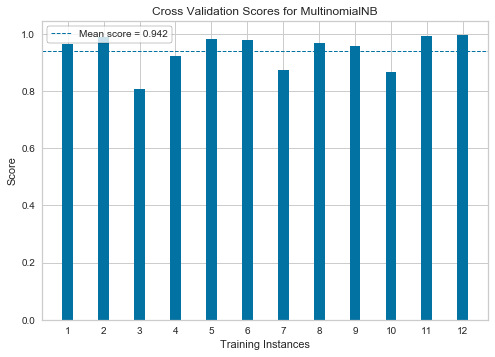

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

# Create a cross-validation strategy
cv = StratifiedKFold(12)

# Create the cv score visualizer
oz = CVScores(
    MultinomialNB(), cv=cv, scoring='f1_weighted'
)

oz.fit(X, y)
oz.poof()

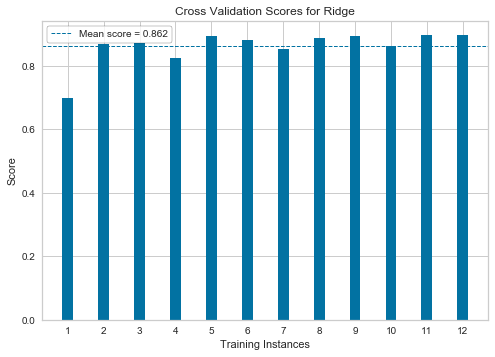

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

energy = pd.read_csv('data/energy/energy.csv')

targets = ["heating load", "cooling load"]
features = [col for col in energy.columns if col not in targets]

X = energy[features]
y = energy[targets[1]]

cv = KFold(12)

oz = CVScores(
    Ridge(), cv=cv, scoring='r2'
)

oz.fit(X, y)
oz.poof()

